In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import splitfolders
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
os.listdir("./Preprocessing")

['ba',
 'ca',
 'da',
 'dha',
 'ga',
 'ha',
 'ja',
 'ka',
 'la',
 'ma',
 'na',
 'nga',
 'nya',
 'pa',
 'ra',
 'sa',
 'ta',
 'tha',
 'wa',
 'ya']

In [3]:
base_dir = "./Preprocessing/"
splitfolders.ratio(base_dir, output='./Preprocessing_output', seed=1337, ratio=(.8, .2))

train_dir = os.path.join("./Preprocessing_output", "train")
validation_dir = os.path.join("./Preprocessing_output", "val")

Copying files: 0 files [00:00, ? files/s]

Copying files: 1558 files [00:02, 622.69 files/s]


In [4]:
def check_and_remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                print(f"File rusak ditemukan dan dihapus: {img_path}")
                os.remove(img_path)

check_and_remove_corrupt_images(train_dir)
check_and_remove_corrupt_images(validation_dir)

print("Pemeriksaan dan penghapusan file rusak selesai.")

Pemeriksaan dan penghapusan file rusak selesai.


In [6]:
train_datagen = ImageDataGenerator(rescale=1-(1/255),
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   shear_range=0.1)

validation_datagen = ImageDataGenerator(rescale=1-(1/255))

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 1240 images belonging to 20 classes.
Found 318 images belonging to 20 classes.


In [7]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto',
                    min_delta=0.0001, cooldown=3, min_lr=1e-8
                )

In [11]:
model = Sequential([Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(5e-5), activation='relu', input_shape=(224, 224, 3)),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(5e-5), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(5e-5), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(5e-5), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    GlobalAveragePooling2D(),
                    Flatten(),
                    Dense(20, activation='softmax')])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-2),
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     1

In [13]:
early_stop = EarlyStopping(patience=20)

In [14]:
hist = model.fit(
    train_generator,
    epochs = 100,
    validation_data = validation_generator,
    callbacks=[reduce_on_plateau, early_stop],
    verbose=1
)

Epoch 1/100
39/39 [==============================] - 29s 374ms/step - loss: 3.0796 - accuracy: 0.0774 - val_loss: 93.7934 - val_accuracy: 0.0503 - lr: 0.0100
Epoch 2/100
39/39 [==============================] - 12s 299ms/step - loss: 2.9650 - accuracy: 0.1024 - val_loss: 43.0436 - val_accuracy: 0.0503 - lr: 0.0100
Epoch 3/100
39/39 [==============================] - 12s 302ms/step - loss: 2.9040 - accuracy: 0.1105 - val_loss: 9.8592 - val_accuracy: 0.0503 - lr: 0.0100
Epoch 4/100
39/39 [==============================] - 13s 324ms/step - loss: 2.8244 - accuracy: 0.1315 - val_loss: 10.0178 - val_accuracy: 0.0503 - lr: 0.0100
Epoch 5/100
39/39 [==============================] - 13s 328ms/step - loss: 2.7098 - accuracy: 0.1629 - val_loss: 37.6767 - val_accuracy: 0.0503 - lr: 0.0100
Epoch 6/100
39/39 [==============================] - 12s 295ms/step - loss: 2.5404 - accuracy: 0.2234 - val_loss: 3.2285 - val_accuracy: 0.1006 - lr: 0.0100
Epoch 7/100
39/39 [==============================] - 1

In [15]:
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss: %f" % loss)
print("Validation Accuracy: %f" % accuracy)

10/10 [==============================] - 1s 66ms/step - loss: 0.6559 - accuracy: 0.8459
Validation Loss: 0.6558606028556824
Validation Accuracy: 0.8459119200706482


In [16]:
model.save('CNN1_pre_84_59v2.keras')

1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB dat

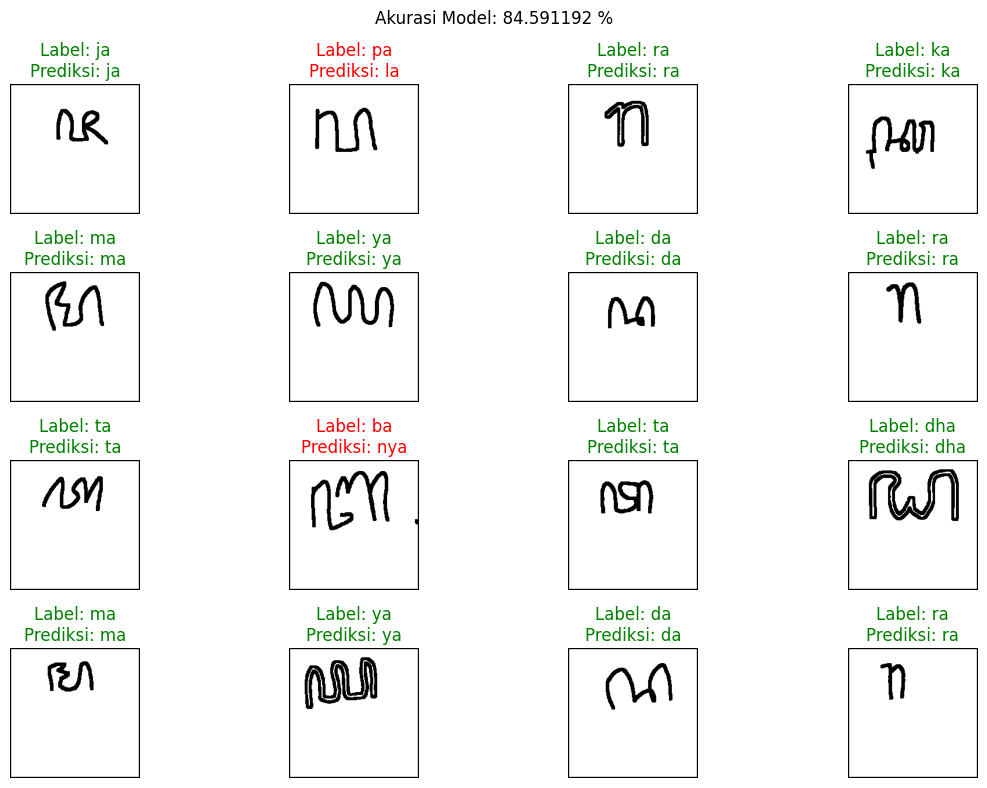

In [38]:
import numpy as np
import matplotlib.pyplot as plt

X_batch, y_batch = next(validation_generator)

preds = model.predict(X_batch)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_batch, axis=1)

daftar_label = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma',
                  'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

fig, axes = plt.subplots(4, 4, figsize=(12, 8))
fig.suptitle("Akurasi Model: %f %%" % (accuracy*100))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_batch[i])
    ax.axis('off')

    true_label = daftar_label[true_classes[i]]
    pred_label = daftar_label[pred_classes[i]]

    font_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"Label: {true_label}\nPrediksi: {pred_label}", color=font_color)

plt.tight_layout()
plt.show()